In [3]:
install.packages("vctrs", repos = "https://cloud.r-project.org/")
install.packages("dplyr", repos = "https://cloud.r-project.org/")
install.packages("Matrix")
install.packages("doParallel")
install.packages("foreach")
library(dplyr)
library(Matrix)
library(parallel)
library(doParallel)
library(foreach)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Warning message in install.packages("Matrix"):
“installation of package ‘Matrix’ had non-zero exit status”
Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [31]:
final_analysis_df = readRDS("Olist/final_analysis_df.rds")
df_for_encoding = readRDS("Olist/df_for_encoding.rds")

In [32]:
# Create predictors dataframe

# First remove identifier and outcome variables
df_for_encoding = final_analysis_df %>% select(-customer_unique_id)

# Save the outcome variable for later use in the model
response_variable = df_for_encoding$RFM_avg

df_for_encoding <- df_for_encoding %>% select(-RFM_avg)



In [33]:
# Remove num_orders, aov and total spend

df_for_encoding <- df_for_encoding[ , !(names(df_for_encoding) %in% c("total_spend", "num_orders", "aov"))]



In [35]:
library(foreach)
library(doParallel)
library(dplyr)

# Register parallel backend
num_cores <- detectCores() # or set a specific number of cores you want to use
cl <- makeCluster(num_cores)
registerDoParallel(cl)

# Assuming 'df_for_encoding' is your initial dataframe
# And 'categorical_vars' and 'continuous_vars' are defined as before
names(df_for_encoding)[names(df_for_encoding) == "mean(income_pc)"] <- "mean_income_pc"

continuous_vars <- c("avg_installments", "reviews_per_customer", "avg_review_score_per_customer", "mean_income_pc")
categorical_vars <- c("customer_zip_code_prefix", "customer_city", "customer_state", 
                      "most_common_weekday", "most_common_month", "urban_rural")

batch_size = 1000


# Initialize an empty dataframe for standardized data
standardized_data <- data.frame(matrix(ncol = length(continuous_vars), nrow = 0))
colnames(standardized_data) <- continuous_vars

# Process in batches with parallelization
for (i in seq(1, nrow(df_for_encoding), by = batch_size)) {
    batch <- df_for_encoding[i:min(i+batch_size-1, nrow(df_for_encoding)), continuous_vars]
    standardized_batch <- foreach(var = names(batch), .combine = cbind) %dopar% {
        # Define the standardize function within the loop
        standardize <- function(x) (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
        as.vector(standardize(batch[[var]]))
    }
    standardized_data <- rbind(standardized_data, as.data.frame(standardized_batch))
    print(paste("Batch", i, "to", min(i+batch_size-1, nrow(df_for_encoding)), "processed"))

}

# Stop the cluster
stopCluster(cl)

# Replace the original continuous variables with standardized values
df_for_encoding[continuous_vars] <- standardized_data

# Proceed with one-hot encoding (non-parallelized for simplicity)
df_one_hot <- model.matrix(~ . - 1, data = df_for_encoding[categorical_vars])

library(Matrix)

# Convert to sparse matrices
sparse_continuous <- as(df_for_encoding[continuous_vars], "sparseMatrix")
sparse_one_hot <- as(df_one_hot, "sparseMatrix")

# Combine using cBind from Matrix package
df_combined_sparse <- cbind(sparse_continuous, sparse_one_hot)


[1] "Batch 1 to 1000 processed"
[1] "Batch 1001 to 2000 processed"
[1] "Batch 2001 to 3000 processed"
[1] "Batch 3001 to 4000 processed"
[1] "Batch 4001 to 5000 processed"
[1] "Batch 5001 to 6000 processed"
[1] "Batch 6001 to 7000 processed"
[1] "Batch 7001 to 8000 processed"
[1] "Batch 8001 to 9000 processed"
[1] "Batch 9001 to 10000 processed"
[1] "Batch 10001 to 11000 processed"
[1] "Batch 11001 to 12000 processed"
[1] "Batch 12001 to 13000 processed"
[1] "Batch 13001 to 14000 processed"
[1] "Batch 14001 to 15000 processed"
[1] "Batch 15001 to 16000 processed"
[1] "Batch 16001 to 17000 processed"
[1] "Batch 17001 to 18000 processed"
[1] "Batch 18001 to 19000 processed"
[1] "Batch 19001 to 20000 processed"
[1] "Batch 20001 to 21000 processed"
[1] "Batch 21001 to 22000 processed"
[1] "Batch 22001 to 23000 processed"
[1] "Batch 23001 to 24000 processed"
[1] "Batch 24001 to 25000 processed"
[1] "Batch 25001 to 26000 processed"
[1] "Batch 26001 to 27000 processed"
[1] "Batch 27001 to 280

In [36]:
# Save the sparse matrix to an RDS file
saveRDS(df_combined_sparse, file = "Olist/df_combined_sparse.rds")


In [16]:
install.packages("glmnet")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘RcppEigen’




In [37]:
library(glmnet)

# Assuming 'y' is your response variable
# and 'df_combined_sparse' is your predictor matrix

# Fit LASSO model
lasso_model <- glmnet(df_combined_sparse, response_variable, alpha = 1)

# Selecting the best lambda (regularization parameter)
cv_lasso <- cv.glmnet(df_combined_sparse, response_variable, alpha = 1)
best_lambda_lasso <- cv_lasso$lambda.min

# Fit LASSO model with best lambda
lasso_best <- glmnet(df_combined_sparse, response_variable, alpha = 1, lambda = best_lambda_lasso)


In [38]:
# Fit Ridge model
ridge_model <- glmnet(df_combined_sparse, response_variable, alpha = 0)

# Selecting the best lambda
cv_ridge <- cv.glmnet(df_combined_sparse, response_variable, alpha = 0)
best_lambda_ridge <- cv_ridge$lambda.min

# Fit Ridge model with best lambda
ridge_best <- glmnet(df_combined_sparse, response_variable, alpha = 0, lambda = best_lambda_ridge)


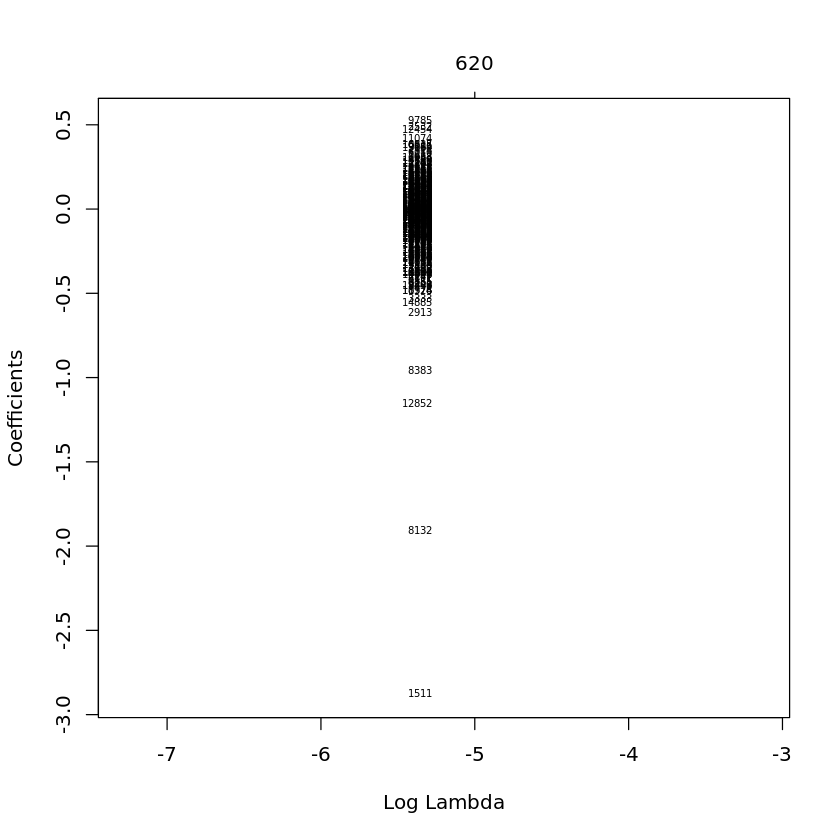

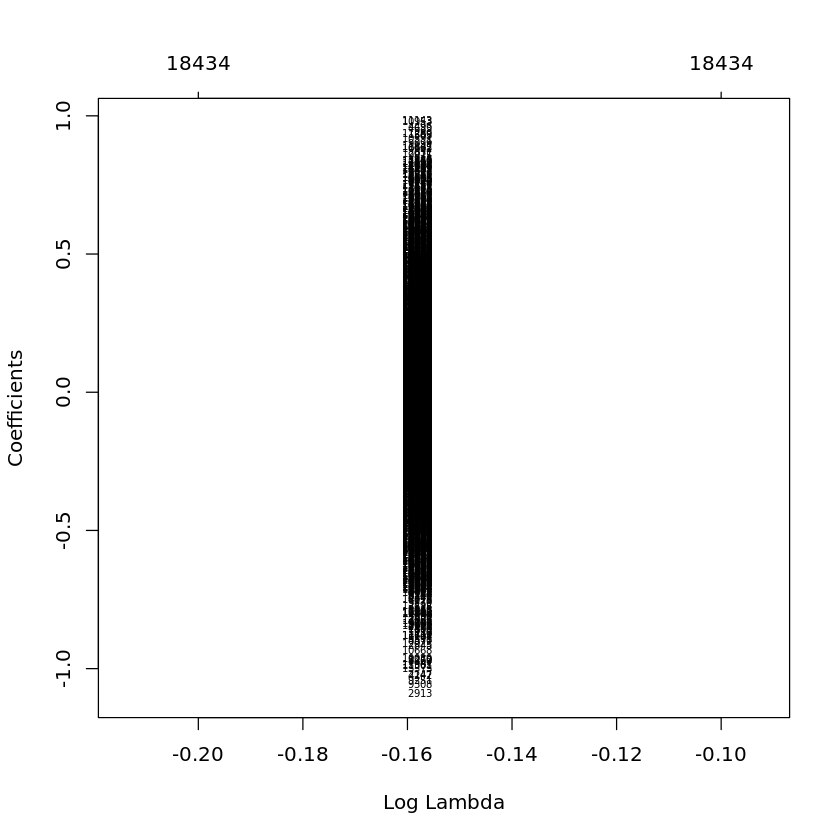

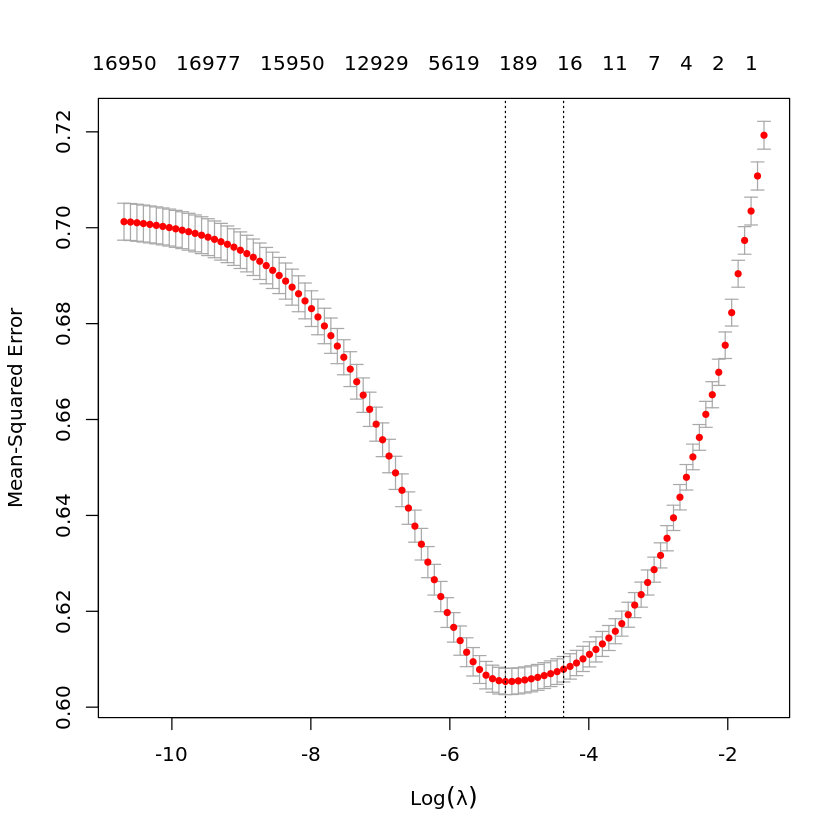

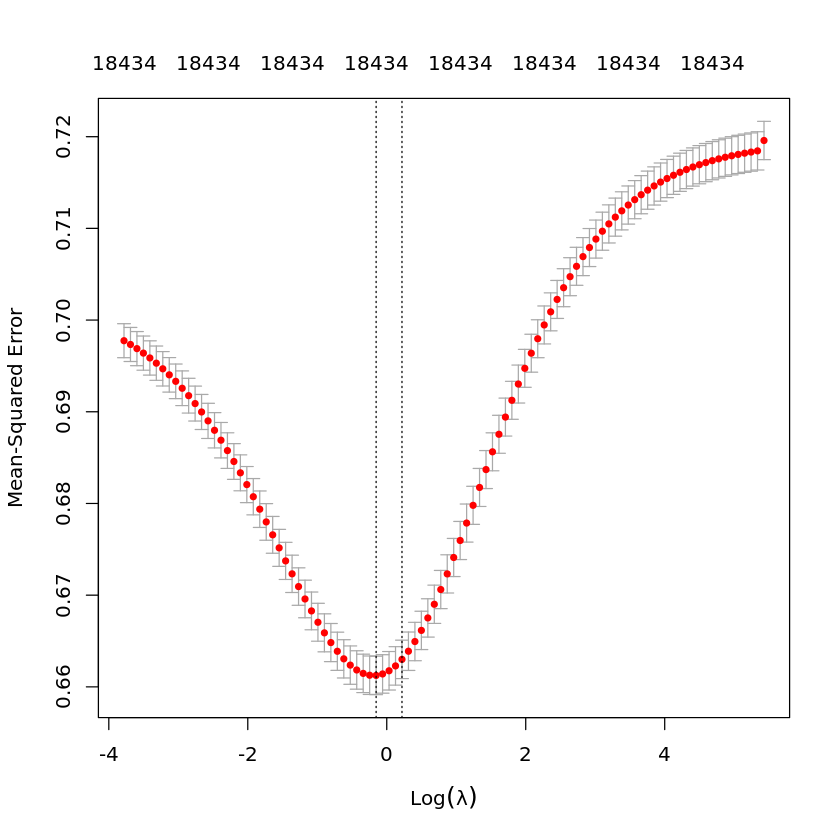

In [39]:
# Plot LASSO coefficients
plot(lasso_best, xvar = "lambda", label = TRUE)

# Plot Ridge coefficients
plot(ridge_best, xvar = "lambda", label = TRUE)

# Plot cross-validation error for LASSO
plot(cv_lasso)

# Plot cross-validation error for Ridge
plot(cv_ridge)


In [40]:
# Save LASSO Coefficients Plot
png(file = "lasso_coefficients_plot.png")
plot(lasso_best, xvar = "lambda", label = TRUE)
dev.off()  # Close the device


png 
  2

In [41]:
# Save Ridge Coefficients Plot
png(file = "ridge_coefficients_plot.png")
plot(ridge_best, xvar = "lambda", label = TRUE)
dev.off()  # Close the device


png 
  2

In [42]:
# Save LASSO Cross-Validation Error Plot
png(file = "lasso_cv_error_plot.png")
plot(cv_lasso)
dev.off()  # Close the device


png 
  2

In [43]:
# Save Ridge Cross-Validation Error Plot
png(file = "ridge_cv_error_plot.png")
plot(cv_ridge)
dev.off()  # Close the device


png 
  2

In [44]:
# Assuming cv_lasso is the result from cv.glmnet
lasso_coefs <- coef(cv_lasso, s = "lambda.1se")

# Number of non-zero coefficients (excluding intercept)
non_zero_coefs <- sum(lasso_coefs[-1, ] != 0)

# Print the number of selected features
print(non_zero_coefs)


[1] 16


In [ ]:
# Extract the coefficients for the value of lambda.1se 
lasso_coefs <- coef(cv_lasso, s = "lambda.1se")

# Coerce the matrix to a regular dense format
lasso_coefs_matrix <- as.matrix(lasso_coefs)

# Create a data frame from the matrix
lasso_coefs_df <- data.frame(
  Feature = rownames(lasso_coefs_matrix),
  Coefficient = lasso_coefs_matrix[, 1]
)

# Remove the intercept and select non-zero coefficients
selected_features <- lasso_coefs_df[lasso_coefs_df$Coefficient != 0 & lasso_coefs_df$Feature != "(Intercept)", , drop = FALSE]

# View the selected features and their coefficients
print(selected_features)

# saveRDS(selected_features, "Olist/impactful_lasso_features.rds")



In [ ]:

# Extract non-zero coefficients from the lasso model at lambda.min
lasso_coefs_min <- coef(cv_lasso, s = "lambda.min")

# Convert the sparse matrix to a regular dense format and exclude the intercept
lasso_coefs_min_dense <- as.matrix(lasso_coefs_min)[-1, , drop = FALSE]  # Excluding the intercept

# Remove rows with zero coefficients
lasso_coefs_min_dense_nonzero = lasso_coefs_min_dense[lasso_coefs_min_dense[, 1] != 0, ]

print(lasso_coefs_min_dense_nonzero)

saveRDS(lasso_coefs_min_dense_nonzero, "Olist/lasso_min_nonzero_coefs.rds")

In [ ]:
# Extract non-zero coefficients from the ridge model at lambda.min
ridge_coefs_min <- coef(cv_ridge, s = "lambda.min")

# Convert the sparse matrix to a regular dense format and exclude the intercept
ridge_coefs_min_dense <- as.matrix(ridge_coefs_min)[-1, , drop = FALSE]  # Excluding the intercept

# Remove rows with zero coefficients
ridge_coefs_min_dense_nonzero = ridge_coefs_min_dense[ridge_coefs_min_dense[, 1] != 0, ]

print(ridge_coefs_min_dense_nonzero)

saveRDS(ridge_coefs_min_dense_nonzero, "Olist/ridge_min_nonzero_coefs.rds")